# Forecasting

## Importing Libraries and Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from collections import defaultdict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
import random
import xgboost as xgb
from prophet import Prophet
import os
import json

In [2]:
df = pd.read_csv('../../Stationary/Data/walmart.csv')

In [3]:
def cleaning(df_copy: pd.DataFrame) -> pd.DataFrame:
    df = df_copy.copy(deep=True)
    df['Date'] = pd.to_datetime(df['Date'], format=r"%d-%m-%Y")
    df['Store'] = df['Store'].astype(pd.StringDtype()).astype('category')
    df['Holiday_Flag'] = df['Holiday_Flag'].astype(pd.BooleanDtype())
    df = df.rename(columns={col: col.lower() for col in df.columns})
    return df

df = cleaning(df)

## Methodology

### Data

- The data used for this analysis is from [Kaggle](https://www.kaggle.com/datasets/rutuspatel/walmart-dataset-retail)
- The data consists primarily of the weekly sales for 45 stores from 2010 to 2012
- Since the sales differ across stores, I will be forecasting sales for each store separately

### Modeling

- Following models are used for forecasting:
  1. Holt Winters Exponential Smoothing
  2. ARIMA
  3. ARIMAX
  4. SARIMA
  5. SARIMAX
  6. FB Prophet
  7. XGBoost

### Training

- We have 143 weeks of data for each store. The goal is to make long term forecasts for the next 12 weeks
- So, last 12 weeks of data are separated for future forecasting
- Rest of the 131 weeks are subsequently split into training and testing sets
- Given that the data has yearly repeating patterns, the model will need whole years of data to capture these patterns
- So, 105 weeks (2 years) of data is used for training and rest 26 weeks are used for testing

### Evaluation

- All the models internally use different loss functions to optimize the solution. But, Mean Absolute Error (MAE) is used to evaluate the performance of the models and compare them
- For statistical time series models like ARIMA, SARIMA, SARIMAX; after training all their sub-models on 105 weeks of data, Alkaline Information Criterion (AIC) is used to determine the best model
- The, all the models are evaluated on the 26 weeks of testing data using growing window forecasting. Basically, the model will predict 1 week ahead and compare it with the actual value. Then, re-train on the training data + the actual value of the next week and repeat the process until the end of the testing data
- Finally, the model with the lowest MAE is selected as the best model to forecast the next 12 weeks

## Different models

1. Holt Winters i.e. Triple Exponential Smoothing 

2. ARIMA with orders
    - (6, 1, 4)
    - (6, 1, 5)
    - (6, 2, 4)
    - (6, 2, 5)
    - (9, 2, 4)
    - (9, 2, 5)

3. SARIMA with orders
    - (6, 1, 4), (2, 1, 5, 52)
    - (6, 1, 5), (2, 1, 5, 52)
    - (6, 2, 4), (2, 1, 5, 52)
    - (6, 2, 5), (2, 1, 5, 52)
    - (9, 2, 4), (2, 1, 5, 52)
    - (9, 2, 5), (2, 1, 5, 52)

4. SARIMAX with cpi, holiday_flag and orders
    - (6, 1, 4), (2, 1, 5, 52)
    - (6, 1, 5), (2, 1, 5, 52)
    - (6, 2, 4), (2, 1, 5, 52)
    - (6, 2, 5), (2, 1, 5, 52)
    - (9, 2, 4), (2, 1, 5, 52)
    - (9, 2, 5), (2, 1, 5, 52)

5. XGBoost with
    - month
    - year
    - holiday_flag
    - CPI
    - lagged sales

6. FB Prophet

## Saving and/or loading previous results

In [4]:

def custom_encoder(o):
    """
    Custom encoder that converts non-serializable objects into a
    serializable format with type markers. Now handles NumPy arrays,
    tuples, and pandas Timestamp objects.
    """
    if isinstance(o, np.ndarray):
        return {"__ndarray__": o.tolist()}
    if isinstance(o, tuple):
        return {"__tuple__": list(o)}
    if isinstance(o, pd.Timestamp):
        return {"__pdtimestamp__": o.isoformat()}
    raise TypeError(f"Object of type {type(o)} is not JSON serializable")

def custom_decoder(d):
    """
    Checks for type markers in the dictionary and converts them back
    to their original types. Now converts the pandas Timestamp marker
    back to a pd.Timestamp object.
    """
    if "__ndarray__" in d:
        return np.array(d["__ndarray__"])
    if "__tuple__" in d:
        return tuple(d["__tuple__"])
    if "__pdtimestamp__" in d:
        return pd.Timestamp(d["__pdtimestamp__"])
    return d

def load_all_results(file_path="results.json"):
    """
    Loads the full results dictionary from file using custom_decoder.
    If the file does not exist, returns an empty dictionary.
    """
    if os.path.exists(file_path):
        with open(file_path, "r") as file:
            data = json.load(file, object_hook=custom_decoder)
            return data
    return {}


def save_all_results(results, file_path="results.json"):
    """
    Saves the full results dictionary to file using custom_encoder.
    """
    with open(file_path, "w") as file:
        json.dump(results, file, default=custom_encoder, indent=4)

## Train, Test and Eval split

In [5]:
# Get sorted unique dates
unique_dates = sorted(df['date'].unique())
total_weeks = len(unique_dates)

# Reserve final 12 weeks for hold-out (final forecast)
holdout_dates = unique_dates[-12:]

# The remaining weeks (training + validation): should be total_weeks - 12.
train_val_dates = unique_dates[:-12]

# Split the 131 weeks: the first 105 weeks for training and the next 26 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

## Loss metric

## Data Preparation

In [6]:
# Get the unique store identifiers (assuming 'store' is categorical)
stores = df['store'].cat.categories.tolist()

# Create a results dictionary to store individual store results, and later aggregated metrics
results = load_all_results()

# We will forecast in 2-week horizons over the 26 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 26/2 = 13

## Model Training

### Holt Winters 

#### Training

In [8]:
if 'HoltWinters' not in results:
    results['HoltWinters'] = {
        "store_results": {},
        "aggregated_metrics": {}
    }

# Loop over each store
for store in stores:
    # Filter the store’s data and sort it by date.
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the store data into training and validation sets based on date.
    train_store_df = store_df[store_df['date'].isin(train_dates)]
    valid_store_df = store_df[store_df['date'].isin(val_dates)]
    
    # Extract the weekly sales series (using 'date' as index)
    train_series = train_store_df.set_index('date')['weekly_sales']
    
    # Initialize lists to collect forecasts and actual values as we do a growing-window forecast.
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Start with the training series; as we move forward, this will grow.
    series_gw = train_series.copy()
    
    # Iterate over each 2-week forecast window
    for i in range(n_forecast_iterations):
        # Fit the Holt–Winters (triple exponential smoothing) model:
        # We assume an additive trend and additive seasonal component with season_length 52.

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            
            model = ExponentialSmoothing(
                series_gw,
                trend="add",
                seasonal="add",
                seasonal_periods=52,
                initialization_method="estimated",
            )

            fit = model.fit(optimized=True, remove_bias=True, use_brute=True)
            
            # Forecast the next 'forecast_horizon' weeks
            forecast = fit.forecast(forecast_horizon)
        
        # Determine the forecast dates from our validation dates.
        # For each iteration, select the next 2 weeks in order.
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
        
        # Get the actual weekly sales for the forecast dates from the validation set.
        valid_series = valid_store_df.set_index('date')['weekly_sales']
        actual = valid_series.loc[fc_dates]
        
        # Append these forecasts and actuals to our lists.
        store_predictions.extend(forecast.values)
        store_actuals.extend(actual.values)
        forecast_dates_list.extend(fc_dates)
        
        # Update the growing window: as if we received these observations.
        # (Using pd.concat instead of .append to avoid deprecation warnings.)
        series_gw = pd.concat([series_gw, actual]).sort_index()
    
    # After finishing the growing window forecast, compute rmse for the store.
    store_predictions = np.array(store_predictions).tolist()
    store_actuals = np.array(store_actuals).tolist()
    store_mae = float(mean_absolute_error(store_actuals, store_predictions))
    
    # Save results for this store.
    results['HoltWinters']['store_results'][store] = {
        'forecast_dates': forecast_dates_list,
        'predictions': store_predictions,
        'actuals': store_actuals,
        'mae': store_mae
    }

#### Calculate Errors

In [9]:
all_mae = []
for store in stores:
    store_mae = results['HoltWinters']['store_results'][store]['mae']
    all_mae.append(store_mae)

avg_mae = float(np.mean(all_mae))
std_mae = float(np.std(all_mae))

results['HoltWinters']['aggregated_metrics'] = {
    'avg_mae': avg_mae,
    'std_mae': std_mae
}

pd.Series(all_mae).describe()

count        45.000000
mean      42961.345915
std       26876.922926
min        9307.971428
25%       23044.419884
50%       37918.606065
75%       59191.844352
max      126763.135885
dtype: float64

In [10]:
save_all_results(results)

#### Visualize predictions

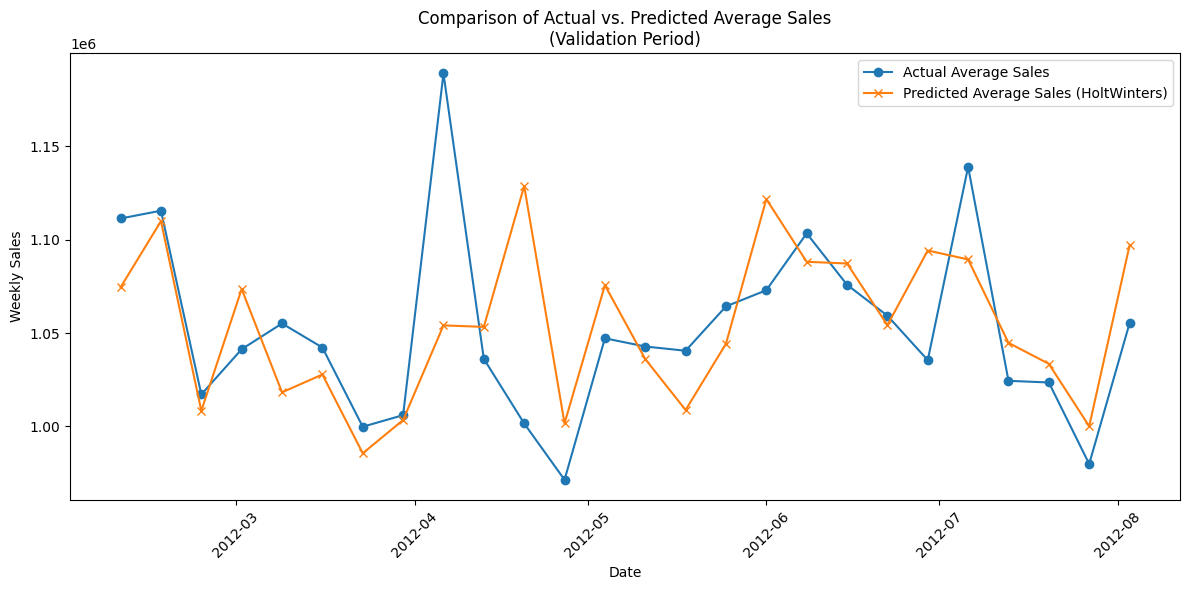

In [11]:
# Initialize dictionaries to aggregate forecast values by date.
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

# Loop through each store's results
for store in stores:
    store_result = results['HoltWinters']['store_results'][store]
    for dt, pred, actual in zip(store_result['forecast_dates'],
                                  store_result['predictions'],
                                  store_result['actuals']):
        # Convert dt into a pd.Timestamp (if not already)
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(actual)

# Sort the forecasted dates
sorted_dates = sorted(pred_by_date.keys())

# For each date, compute the average predicted and actual weekly sales.
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

# Plot the actual vs. predicted average sales
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x',
         label='Predicted Average Sales (HoltWinters)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Comparison of Actual vs. Predicted Average Sales\n(Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### ARIMA

#### Training

In [12]:
results = load_all_results()

In [16]:
if 'ARIMA' not in results:
    results['ARIMA'] = {
        "store_results": {},
        "aggregated_metrics": {}
    }

# Define candidate ARIMA orders to consider
candidate_orders = [(6, 1, 4), (6, 1, 5), (6, 2, 4), (6, 2, 5)]

# Get unique stores (assuming the store column is categorical)
stores = df['store'].cat.categories.tolist()

# Loop over each store
for store in stores:
    # Filter the store’s data and sort by date
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the data into training and validation based on date.
    train_store_df = store_df[store_df['date'].isin(train_dates)]
    valid_store_df = store_df[store_df['date'].isin(val_dates)]
    
    # Extract the weekly sales series from training data.
    train_series = train_store_df.set_index('date')['weekly_sales']
    
    # First, determine the best ARIMA order by fitting each candidate on just the
    # training portion (105 weeks) and comparing their AIC.
    best_aic = np.inf
    best_order = None
    aic_bic = pd.DataFrame(columns=['order', 'aic', 'bic'], index = list(range(len(candidate_orders)))) 
    for idx, order in enumerate(candidate_orders):
        try:
            # Suppress warnings during the ARIMA fitting
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = ARIMA(train_series, order=order)
                fit_model = model.fit()
                aic_bic.iloc[idx]['order'] = order
                aic_bic.iloc[idx]['aic'] = fit_model.aic
                aic_bic.iloc[idx]['bic'] = fit_model.bic
                # print(f"For store {store}, order {order}, AIC: {fit_model.aic}, BIC: {fit_model.bic}")
            if fit_model.aic < best_aic:
                best_aic = fit_model.aic
                best_order = order
        except Exception as e:
            print(f"Store {store}, order {order} failed: {e}")
            continue
    
    # Now, using the selected best_order, do a growing-window forecast on the
    # 26-week validation set (forecasting 2 weeks at a time).
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Start the growing window with the training series.
    series_gw = train_series.copy()
    
    # The number of forecast iterations (26 weeks / 2 per iteration).
    n_forecast_iterations = len(val_dates) // forecast_horizon
    
    for i in range(n_forecast_iterations):
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model_gw = ARIMA(series_gw, order=best_order)
                fit_gw = model_gw.fit()
            forecast_result = fit_gw.forecast(steps=forecast_horizon)
        except Exception as e:
            print(f"Store {store}: Forecast iteration {i} failed with error: {e}")
            # If forecasting fails, you can choose to assign missing values.
            forecast_result = np.full(forecast_horizon, series_gw.iloc[-1])
    
        # Identify the forecast dates (next 2 weeks from the validation list)
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
        
        # Get the actual values for these forecast dates
        valid_series = valid_store_df.set_index('date')['weekly_sales']
        actual = valid_series.loc[fc_dates]
    
        # Append predictions, actuals, and forecast dates
        store_predictions.extend(
            forecast_result if isinstance(forecast_result, np.ndarray)
            else forecast_result.tolist()
        )
        store_actuals.extend(actual.values)
        forecast_dates_list.extend(fc_dates)
    
        # Grow the training window with the actual observations just forecasted.
        series_gw = pd.concat([series_gw, actual]).sort_index()
    
    # After finishing the growing window forecast, compute rmse for the store.
    store_predictions = np.array(store_predictions).tolist()
    store_actuals = np.array(store_actuals).tolist()
    store_mae = float(mean_absolute_error(store_actuals, store_predictions))
    
    # Save results for this store.
    results['ARIMA']['store_results'][store] = {
        'best_order': best_order,
        'forecast_dates': forecast_dates_list,
        'predictions': store_predictions,
        'actuals': store_actuals,
        'mae': store_mae
    }

Store 38: Forecast iteration 15 failed with error: LU decomposition error.


#### Calculate Errors

In [17]:
all_mae = []
for store in stores:
    store_mae = results['ARIMA']['store_results'][store]['mae']
    all_mae.append(store_mae)

avg_mae = float(np.mean(all_mae))
std_mae = float(np.std(all_mae))

results['ARIMA']['aggregated_metrics'] = {
    'avg_mae': avg_mae,
    'std_mae': std_mae
}

pd.Series(all_mae).describe()

count        45.000000
mean      55857.767171
std       31973.065994
min        8107.999214
25%       32722.058617
50%       50691.990753
75%       85070.740653
max      128366.846170
dtype: float64

In [18]:
save_all_results(results)

#### Visualize Predictions

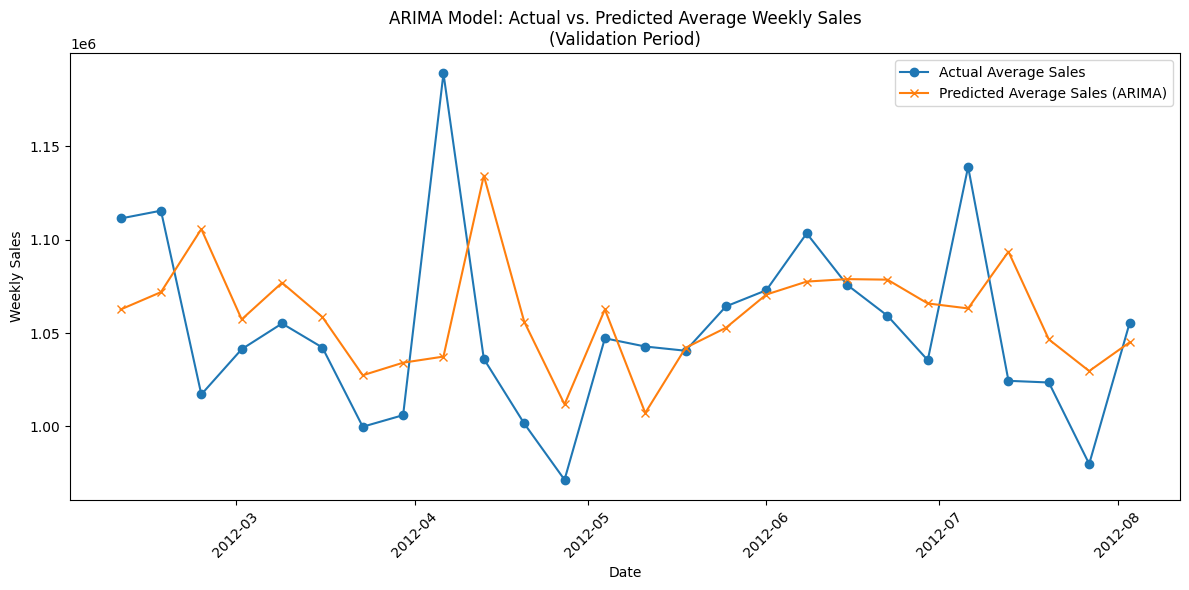

In [19]:
# We'll collect forecasted predictions and actuals per date across all stores.
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    store_result = results['ARIMA']['store_results'][store]
    for dt, pred, act in zip(store_result['forecast_dates'],
                             store_result['predictions'],
                             store_result['actuals']):
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort the forecasted dates
sorted_dates = sorted(pred_by_date.keys())

# Calculate the average predicted and actual sales across stores for each date.
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x',
         label='Predicted Average Sales (ARIMA)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("ARIMA Model: Actual vs. Predicted Average Weekly Sales\n(Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### XGBoost

#### Separate train test split and growing windows

In [20]:
# Split the 131 weeks: the first 105 weeks for training and the next 26 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

# We will forecast in 4-week horizons over the 20 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 20/2 = 10


#### Training

In [21]:
def create_features(df, lags=[1, 2], include_diffs=True):
    df = df.copy()
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["holiday_flag_int"] = df["holiday_flag"].astype(int)
    
    # Create lag features
    for lag in lags:
        df[f"sales_lag_{lag}"] = df["weekly_sales"].shift(periods = lag)
    
    # Create difference features if required.
    if include_diffs:
        # First-order difference: difference between consecutive weekly_sales
        df["sales_diff_1"] = df["weekly_sales"].diff(1)
        # Second-order difference: difference of first differences (or equivalently
        # the two-period difference)
        df["sales_diff_2"] = df["weekly_sales"].diff(2)
    
    # Drop rows with missing values due to lag / difference calculation.
    df = df.dropna()
    return df

In [22]:
results = load_all_results()

if 'XGBoost' not in results:
    results['XGBoost'] = {
        "store_results": {},
        "aggregated_metrics": {}
    }

# Assume stores are available from the categorical 'store' column.
stores = df["store"].cat.categories.tolist()

# Define lag values. (These are used in addition to our newly added difference features.)
lag_features = [1, 2, 3, 4, 5, 6]

for store in stores:
    # Filter and sort the data for the current store.
    store_df = df[df["store"] == store].sort_values("date").reset_index(drop=True)

    # Split the store's data into training (105 weeks) and validation (26 weeks).
    train_store_df = store_df[store_df["date"].isin(train_dates)]
    valid_store_df = store_df[store_df["date"].isin(val_dates)]
    
    # Start the growing window with the training data.
    data_gw = train_store_df.copy()
    data_gw = data_gw.sort_values("date").reset_index(drop=True)
    
    # Lists to hold forecasts/actuals for the current store.
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Calculate the number of iterations based on the forecast horizon.
    n_iter = len(val_dates) // forecast_horizon
    
    for i in range(n_iter):
        # --- TRAINING STEP ---
        # Build the training features using the helper function (includes diffs).
        train_feats = create_features(data_gw, lags=lag_features, include_diffs=True)
        
        # Define the feature set.
        # Calendar features, holiday_flag, CPI, lags, and differences.
        X_train = train_feats[[
            "month",
            "year",
            "holiday_flag_int",
            "cpi",
            "sales_lag_1",
            "sales_lag_2",
            "sales_lag_3",
            "sales_lag_4",
            "sales_lag_5",
            "sales_lag_6",
            "sales_diff_1",
            "sales_diff_2"
        ]]
        y_train = train_feats["weekly_sales"]
        
        # Train the XGBoost model. Adjust hyperparameters as needed.
        model = xgb.XGBRegressor(
            objective="reg:squarederror",
            n_estimators=50,
            max_depth=5,
            learning_rate=0.075,
            random_state=42,
        )
        model.fit(X_train, y_train)
        
        # --- FORECASTING STEP ---
        # Determine forecast dates for the current window (next 2 weeks).
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
        
        fc_preds = []
        for fc_date in fc_dates:
            # Extract calendar and economic features from the validation set.
            row = valid_store_df[valid_store_df["date"] == fc_date]
            if row.empty:
                continue
            month = row["date"].dt.month.values[0]
            year = row["date"].dt.year.values[0]
            holiday_flag_int = int(row["holiday_flag"].values[0])
            CPI_val = row["cpi"].values[0]
            
            # --- Compute lag features from data_gw ---
            # Ensure we have enough observations to compute both lag and difference features.
            sales_lag_1 = data_gw["weekly_sales"].iloc[-1]
            sales_lag_2 = data_gw["weekly_sales"].iloc[-2] #if len(data_gw) >= 2 else sales_lag_1
            sales_lag_3 = data_gw["weekly_sales"].iloc[-3]
            sales_lag_4 = data_gw["weekly_sales"].iloc[-4] #if len(data_gw) >= 2 else sales_lag_1
            sales_lag_5 = data_gw["weekly_sales"].iloc[-3]
            sales_lag_6 = data_gw["weekly_sales"].iloc[-4] #if len(data_gw) >= 2 else sales_lag_1
            
            # Compute first difference feature
            sales_diff_1 = sales_lag_1 - sales_lag_2
            
            # For the second difference, we need the third most recent data point.
            if len(data_gw) >= 3:
                # sales_lag_3 = data_gw["weekly_sales"].iloc[-3]
                sales_diff_2 = sales_lag_1 - 2 * sales_lag_2 + sales_lag_3
            else:
                sales_diff_2 = sales_diff_1  # Fallback if not enough data
            
            # Construct a DataFrame for this forecast sample.
            X_fc = pd.DataFrame({
                "month": [month],
                "year": [year],
                "holiday_flag_int": [holiday_flag_int],
                "cpi": [CPI_val],
                "sales_lag_1": [sales_lag_1],
                "sales_lag_2": [sales_lag_2],
                "sales_lag_3": [sales_lag_3],
                "sales_lag_4": [sales_lag_4],
                "sales_lag_5": [sales_lag_5],
                "sales_lag_6": [sales_lag_6],
                "sales_diff_1": [sales_diff_1],
                "sales_diff_2": [sales_diff_2],
            })
            
            # Generate the prediction for the current forecast date.
            pred = model.predict(X_fc)[0]
            fc_preds.append(pred)
            
            # Append the predicted record to the growing window data.
            # Some features (e.g., temperature/fuel_price/unemployment) may not be available.
            new_row = pd.DataFrame({
                "store": [store],
                "date": [fc_date],
                "weekly_sales": [row["weekly_sales"].values[0]],
                "holiday_flag": [row["holiday_flag"].values[0]],
                "temperature": [np.nan],
                "fuel_price": [np.nan],
                "cpi": [CPI_val],
                "unemployment": [np.nan],
            })
            data_gw = pd.concat([data_gw, new_row], ignore_index=True)
            data_gw = data_gw.sort_values("date").reset_index(drop=True)
        
        # Get actual weekly_sales for these forecast dates.
        actual_vals = []
        for fc_date in fc_dates:
            act_row = valid_store_df[valid_store_df["date"] == fc_date]
            if act_row.empty:
                continue
            actual_vals.append(act_row["weekly_sales"].values[0])
        
        store_predictions.extend(fc_preds)
        store_actuals.extend(actual_vals)
        forecast_dates_list.extend(fc_dates)
    

    store_predictions = np.array(store_predictions).tolist()
    store_actuals = np.array(store_actuals).tolist()
    store_mae = float(mean_absolute_error(store_actuals, store_predictions))
    
    # Save store results in the results dictionary.
    results["XGBoost"]["store_results"][store] = {
        "forecast_dates": forecast_dates_list,
        "predictions": store_predictions,
        "actuals": store_actuals,
        "mae": store_mae,
    }


#### Calculate Errors

In [23]:
all_mae = []
for store in stores:
    store_mae = results['XGBoost']['store_results'][store]['mae']
    all_mae.append(store_mae)

avg_mae = float(np.mean(all_mae))
std_mae = float(np.std(all_mae))

results['XGBoost']['aggregated_metrics'] = {
    'avg_mae': avg_mae,
    'std_mae': std_mae
}

pd.Series(all_mae).describe()

count        45.000000
mean      71033.110247
std       42442.068225
min       10995.485433
25%       35036.849567
50%       63731.893462
75%       98883.153269
max      194336.745769
dtype: float64

In [24]:
save_all_results(results)

#### Visualize Predictions

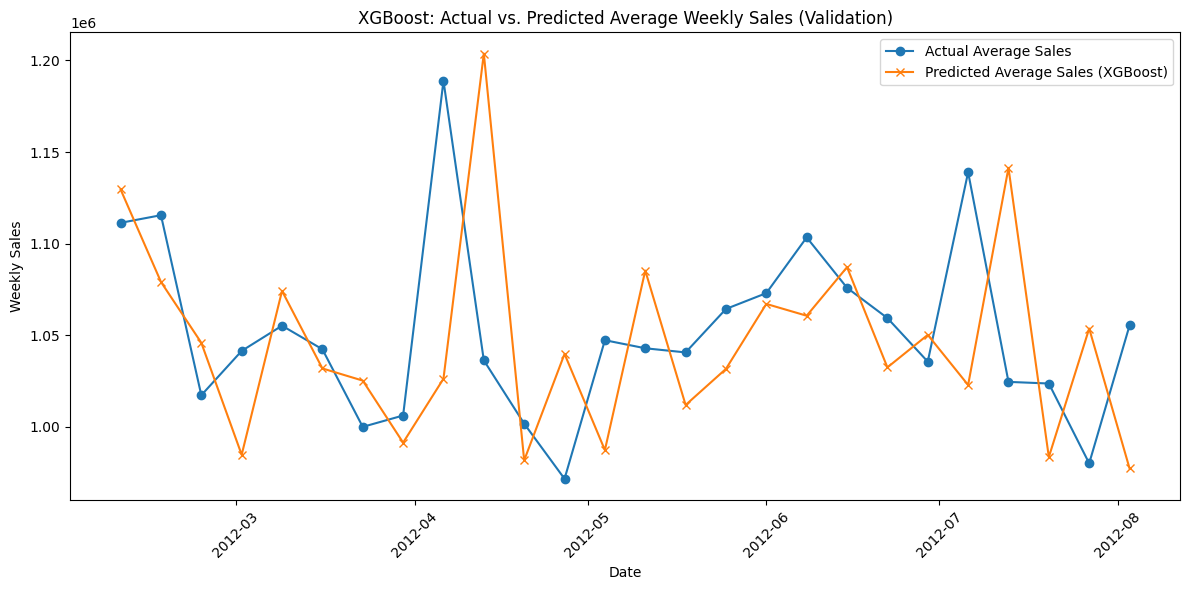

In [25]:
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    store_result = results["XGBoost"]["store_results"][store]
    for dt, pred, act in zip(store_result["forecast_dates"],
                             store_result["predictions"],
                             store_result["actuals"]):
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort the forecast dates and compute the average across stores.
sorted_dates = sorted(pred_by_date.keys())
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker="o", label="Actual Average Sales")
plt.plot(sorted_dates, avg_pred, marker="x", label="Predicted Average Sales (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("XGBoost: Actual vs. Predicted Average Weekly Sales (Validation)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### FB Prophet

#### Separate train test split and growing windows

In [26]:
# Split the 131 weeks: the first 105 weeks for training and the next 26 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

# We will forecast in 4-week horizons over the 20 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 20/2 = 10

# random_stores = random.sample(stores, 25)


#### Training

In [27]:
import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

In [28]:
# Initialize results dictionary for Prophet forecasts.
results = load_all_results()

if 'Prophet' not in results:
    results['Prophet'] = {
        "store_results": {},
        "aggregated_metrics": {}
    }

# Get the list of stores (assuming the store column is categorical).
stores = df["store"].cat.categories.tolist()

holidays = (
    df[df['holiday_flag']][['date']]  # select only rows where holiday_flag is True
    .drop_duplicates()               # remove duplicate dates if needed
    .rename(columns={'date': 'ds'})
)
holidays['holiday'] = 'holiday'  # Label each date with a name (could be more specific)
# Optionally, if you believe the effect spans extra days, add a window:
holidays['lower_window'] = -1  # The holiday's effect starts one day prior
holidays['upper_window'] = 1   # The effect lasts one day after

# Loop over each store.
for store in stores:
    # --- Data Preparation for Prophet ---
    # Filter the data for the current store and sort by date.
    store_df = df[df["store"] == store].sort_values("date").reset_index(drop=True)
    
    # Split store_df into training and validation based on your date lists.
    train_store_df = store_df[store_df["date"].isin(train_dates)]
    valid_store_df = store_df[store_df["date"].isin(val_dates)]
    
    # Convert to Prophet's expected format: "ds" (for date) and "y" (for weekly_sales).
    train_prophet = train_store_df[["date", "weekly_sales"]].rename(
        columns={"date": "ds", "weekly_sales": "y"}
    )
    valid_prophet = valid_store_df[["date", "weekly_sales"]].rename(
        columns={"date": "ds", "weekly_sales": "y"}
    )
    
    # Initialize lists to store forecasts, actuals, and the forecast dates.
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Determine the number of forecast iterations (e.g., for 26 weeks with a 2-week horizon).
    n_iter = len(valid_prophet) // forecast_horizon
    valid_dates = valid_prophet["ds"].tolist()  # these should already be sorted
    
    # Growing-window forecast loop.
    for i in range(n_iter):
        # Initialize the Prophet model with appropriate parameters
        model = Prophet(
            growth="linear",                # Use a linear trend.
            changepoints=None,              # Let Prophet automatically pick changepoints.
            n_changepoints=25,              # Default number of potential changepoints.
            changepoint_range=0.8,            # Use the first 80% of the history for changepoint detection.
            yearly_seasonality=True,        # Include yearly seasonality (important for holidays).
            weekly_seasonality=False,        # Include weekly seasonality (even for weekly data, if relevant).
            daily_seasonality=False,        # Daily seasonality is not applicable for weekly data.
            holidays=holidays,              # Pass in your holidays DataFrame.
            seasonality_mode="additive",    # Use an additive seasonality.
            seasonality_prior_scale=10.0,   # Default prior scale for seasonal effects.
            holidays_prior_scale=10.0,      # Default prior scale for holiday effects.
            changepoint_prior_scale=0.05,   # Controls the flexibility of trend changepoints.
            mcmc_samples=0,                 # Use MAP estimation for faster fitting.
            interval_width=0.80,            # 80% prediction intervals.
            uncertainty_samples=1000,       # Number of draws for uncertainty estimation.
            stan_backend=None,              # Automatically select a Stan backend.
            holidays_mode='additive'        # Use additive holiday effects.
        )
        model.fit(train_prophet)
        
        # Determine the current forecast dates from the validation set.
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = valid_dates[fc_start:fc_end]
        
        # Create a "future" dataframe with the forecast dates.
        future = pd.DataFrame({"ds": fc_dates})
        forecast = model.predict(future)
        predictions = forecast["yhat"].values
        
        # Retrieve the actual observed sales for these fc_dates.
        actual_vals = valid_prophet[valid_prophet["ds"].isin(fc_dates)]["y"].values
        
        # Store predictions, actuals, and the associated dates.
        store_predictions.extend(predictions)
        store_actuals.extend(actual_vals)
        forecast_dates_list.extend(fc_dates)
        
        # IMPORTANT: Grow the training set with the ACTUAL observed values from the validation set.
        new_train = valid_prophet[valid_prophet["ds"].isin(fc_dates)]
        train_prophet = pd.concat([train_prophet, new_train]).sort_values("ds").reset_index(drop=True)
    
    store_predictions = np.array(store_predictions).tolist()
    store_actuals = np.array(store_actuals).tolist()
    store_mae = float(mean_absolute_error(store_actuals, store_predictions))
    
    # Save the store-specific results.
    results["Prophet"]["store_results"][store] = {
        "forecast_dates": forecast_dates_list,
        "predictions": store_predictions,
        "actuals": store_actuals,
        "mae": store_mae,
    }


#### Calculate Errors

In [29]:
all_mae = []
for store in stores:
    store_mae = results['Prophet']['store_results'][store]['mae']
    all_mae.append(store_mae)

avg_mae = float(np.mean(all_mae))
std_mae = float(np.std(all_mae))

results['Prophet']['aggregated_metrics'] = {
    'avg_mae': avg_mae,
    'std_mae': std_mae
}

pd.Series(all_mae).describe()

count        45.000000
mean      47723.386355
std       30315.527289
min        8256.784922
25%       28595.507719
50%       39556.643287
75%       63825.478654
max      149736.209768
dtype: float64

In [30]:
save_all_results(results)

#### Visualize Predictions

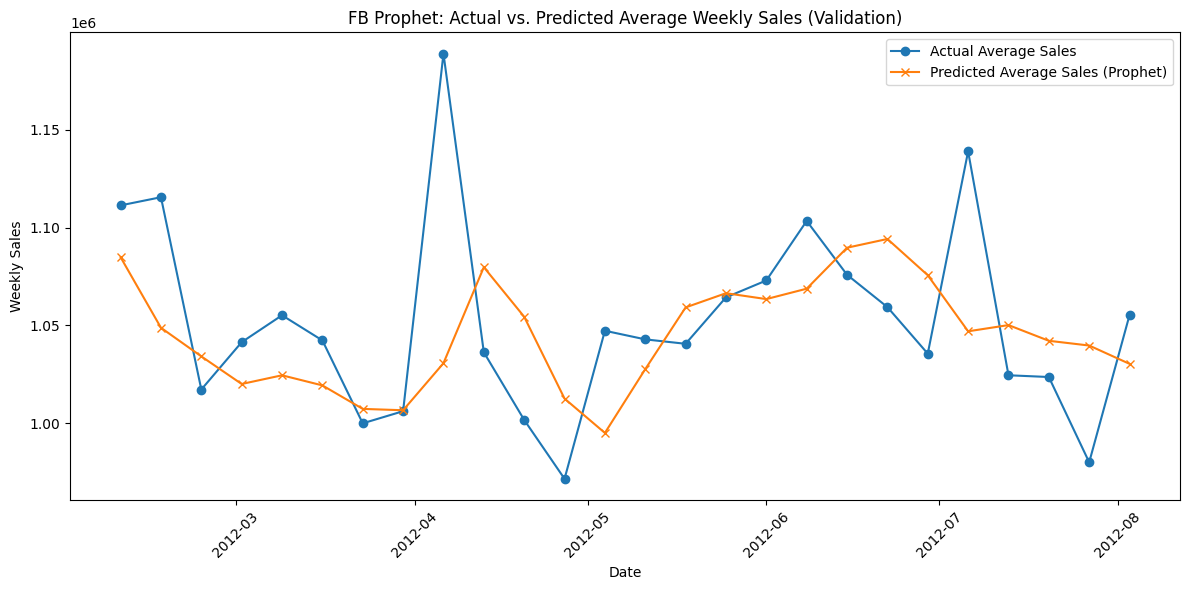

In [31]:
# Aggregate predicted and actual values by forecast date across all stores.
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    store_result = results["Prophet"]["store_results"][store]
    for dt, pred, act in zip(store_result["forecast_dates"], 
                             store_result["predictions"], 
                             store_result["actuals"]):
        # Make sure that the forecast date is a pd.Timestamp.
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort forecast dates.
sorted_dates = sorted(pred_by_date.keys())

# Compute the average prediction and actual sales for each date.
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker="o", label="Actual Average Sales")
plt.plot(sorted_dates, avg_pred, marker="x", label="Predicted Average Sales (Prophet)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("FB Prophet: Actual vs. Predicted Average Weekly Sales (Validation)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### SARIMA

#### Separate train test split and growing windows

In [ ]:
# Split the 131 weeks: the first 111 weeks for training and the next 20 weeks for validation
train_dates = train_val_dates[:105]
val_dates = train_val_dates[105:]

# We will forecast in 4-week horizons over the 20 validation weeks.
forecast_horizon = 1
n_forecast_iterations = len(val_dates) // forecast_horizon  # should be 20/2 = 10

random_stores = random.sample(stores, 25)

#### Training

In [ ]:
results = load_all_results()

if 'SARIMA' not in results:
    results['SARIMA'] = {
        "store_results": {},
        "aggregated_metrics": {}
    }

# Define candidate non-seasonal orders for SARIMA
candidate_orders = [(6, 1, 4)] # , (6, 1, 5), (6, 2, 4), (6, 2, 5)
# Fixed seasonal order: (P, D, Q, m)
seasonal_order = (2, 1, 5, 52)

# Loop over each store
for store in random_stores:
    # Filter the store’s data and sort by date
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the store data into training and validation based on date
    train_store_df = store_df[store_df['date'].isin(train_dates)]
    valid_store_df = store_df[store_df['date'].isin(val_dates)]
    
    # Convert training data into a time series with date as index
    train_series = train_store_df.set_index('date')['weekly_sales']
    
    # -----------------------------------------------------
    # Step 1: Model Selection -- Choose Best Non-Seasonal Order
    # -----------------------------------------------------
    best_aic = np.inf
    best_order = None
    # aic_bic = pd.DataFrame(columns=['order', 'aic', 'bic'], index = list(range(len(candidate_orders)))) 
    for order in candidate_orders:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = SARIMAX(train_series,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                fit_model = model.fit(disp=False)
                # aic_bic.iloc[idx]['order'] = order
                # aic_bic.iloc[idx]['aic'] = fit_model.aic
                # aic_bic.iloc[idx]['bic'] = fit_model.bic
                # print(f"For store {store}, order {order}, AIC: {fit_model.aic}, BIC: {fit_model.bic}")
            # if fit_model.aic < best_aic:
            #     best_aic = fit_model.aic
                best_order = order
        except Exception as e:
            print(f"Store {store}, SARIMA candidate order {order} failed: {e}")
            continue

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        print(f"Store {store} -- Selected SARIMA order: {best_order}, "
            f"Seasonal: {seasonal_order} (AIC: {fit_model.aic}) (BIC: {fit_model.bic})")
    
    # -----------------------------------------------------
    # Step 2: Growing-Window Forecast with Selected SARIMA Order
    # -----------------------------------------------------
    store_predictions = []
    store_actuals = []
    forecast_dates_list = []
    
    # Start with the training series as the initial window
    series_gw = train_series.copy()
    
    # Number of forecast iterations (26 weeks / forecast_horizon weeks per forecast)
    n_forecast_iterations = len(val_dates) // forecast_horizon
    
    for i in range(n_forecast_iterations):
        print(f"Forecast iteration {i+1} of {n_forecast_iterations}")
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model_gw = SARIMAX(series_gw,
                                   order=best_order,
                                   seasonal_order=seasonal_order,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
                fit_gw = model_gw.fit(disp=False)
                forecast_result = fit_gw.forecast(steps=forecast_horizon)
        except Exception as e:
            print(f"Store {store}: Forecast iteration {i} failed: {e}")
            forecast_result = np.full(forecast_horizon, np.nan)
    
        # Identify forecast dates (next 2 weeks from validation dates)
        fc_start = i * forecast_horizon
        fc_end = (i + 1) * forecast_horizon
        fc_dates = val_dates[fc_start:fc_end]
    
        # Get the actual values from the validation set for these dates
        valid_series = valid_store_df.set_index('date')['weekly_sales']
        actual = valid_series.loc[fc_dates]
    
        # Append forecasts, actual values, and dates
        store_predictions.extend(
            forecast_result if isinstance(forecast_result, np.ndarray)
            else forecast_result.tolist()
        )
        store_actuals.extend(actual.values)
        forecast_dates_list.extend(fc_dates)
    
        # Update the growing window with the actual values (simulate receiving new data)
        series_gw = pd.concat([series_gw, actual]).sort_index()
    
    # Compute store-level rmse for SARIMA forecasts
    store_predictions = np.array(store_predictions).tolist()
    store_actuals = np.array(store_actuals).tolist()
    store_mae = float(mean_absolute_error(store_actuals, store_predictions))
    
    # Save store results in the results dictionary
    results['SARIMA']['store_results'][store] = {
        'best_order': best_order,
        'seasonal_order': seasonal_order,
        'forecast_dates': forecast_dates_list,
        'predictions': store_predictions,
        'actuals': store_actuals,
        'mae': store_mae
    }

#### Calculate Errors

In [ ]:
all_mae = []
for store in random_stores:
    store_mae = results['SARIMA']['store_results'][store]['mae']
    all_mae.append(store_mae)

avg_mae = float(np.mean(all_mae))
std_mae = float(np.std(all_mae))

results['SARIMA']['aggregated_metrics'] = {
    'avg_mae': avg_mae,
    'std_mae': std_mae
}

pd.Series(all_mae).describe()

count    25.000000
mean      0.111026
std       0.076609
min       0.030905
25%       0.062593
50%       0.088156
75%       0.132114
max       0.345813
dtype: float64

In [ ]:
save_all_results(results)

#### Visualize Predictions

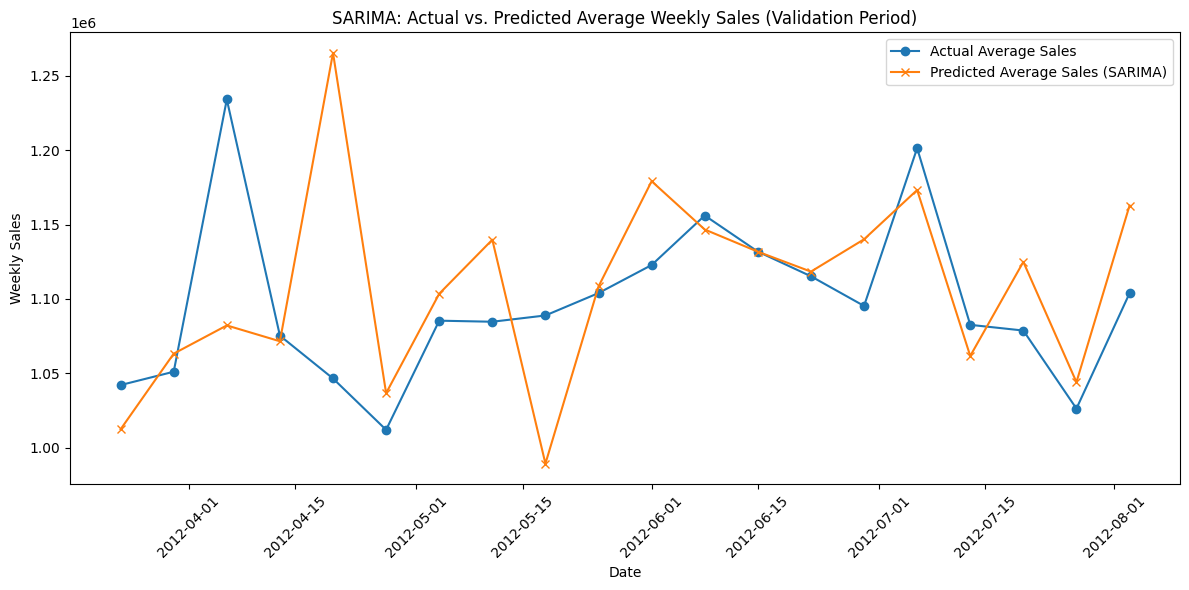

In [ ]:
# Aggregate predicted and actual sales by forecast date (across stores).
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in random_stores:
    store_result = results['SARIMA']['store_results'][store]
    for dt, pred, act in zip(store_result['forecast_dates'],
                             store_result['predictions'],
                             store_result['actuals']):
        dt = pd.to_datetime(dt)
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

# Sort forecast dates
sorted_dates = sorted(pred_by_date.keys())

# Compute the average prediction and actual value for each date
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x', label='Predicted Average Sales (SARIMA)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("SARIMA: Actual vs. Predicted Average Weekly Sales (Validation Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model Comparison

In [32]:
results = load_all_results()

comparison = {
    'index': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'],
}

for model in results.keys():
    all_mae = []
    for store in results.get(model).get('store_results').keys():
        store_mae = results[model]['store_results'][store]['mae']
        all_mae.append(store_mae)
    comparison[model] = pd.Series(all_mae).describe().to_list()

comparison_df = pd.DataFrame(comparison).set_index('index')

In [33]:
comparison_df

,HoltWinters,ARIMA,XGBoost,Prophet
index,,,,
count,45.000000,45.000000,45.000000,45.000000
mean,42961.345915,55857.767171,71033.110247,47723.386355
std,26876.922926,31973.065994,42442.068225,30315.527289
min,9307.971428,8107.999214,10995.485433,8256.784922
25%,23044.419884,32722.058617,35036.849567,28595.507719
50%,37918.606065,50691.990753,63731.893462,39556.643287
75%,59191.844352,85070.740653,98883.153269,63825.478654
max,126763.135885,128366.846170,194336.745769,149736.209768


#### Observations

- Comparing the mean and standard deviation of Mean Absolute errors across stores and across growing window forecasts, **Holt-Winters** outperforms all other models. Hence, it will be used for full forecast of the next 12 weeks.
- Prophet comes in second place with slighly worse MAE scores.
- Same with ARIMA, which comes in third place.
- XGBoost is the worst performer with significantly higher MAE scores. However, peculiarly, when looking at the the plot of actual vs. predicted values, XGBoost would have performed extremely well if only it had predicted values one week ahead. 

## Final Forecast

### Final Training

In [35]:
train_val_dates = sorted(df['date'].unique())[:-12]  # first 131 weeks
holdout_dates = sorted(df['date'].unique())[-12:]      # last 12 weeks

# Get the list of stores
stores = df['store'].cat.categories.tolist()

# Initialize dictionary to collect results per store.
final_results = {}
store_mae_list = []

# Also, prepare dictionaries to aggregate predicted and actual sales by date
pred_by_date = defaultdict(list)
actual_by_date = defaultdict(list)

for store in stores:
    # Filter store data and sort by date
    store_df = df[df['store'] == store].sort_values('date').reset_index(drop=True)
    
    # Split the data:
    # Training + Validation set (131 weeks)
    train_val_df = store_df[store_df['date'].isin(train_val_dates)]
    # Holdout set (last 12 weeks)
    holdout_df   = store_df[store_df['date'].isin(holdout_dates)]
    
    # Set the series for training
    train_val_series = train_val_df.set_index('date')['weekly_sales']
    
    # Fit the Holt Winters model on all 131 weeks.
    # Here we assume an additive model for level, trend, and season,
    # with a seasonal_periods of 52 (or adjust if needed)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        try:
            hw_model = ExponentialSmoothing(
                train_val_series,
                trend="add",
                seasonal="add",
                seasonal_periods=52,
                initialization_method="estimated"
            )
            hw_fit = hw_model.fit(optimized=True)
        except Exception as e:
            print(f"Store {store}: Model fit failed: {e}")
            continue
        
        # Forecast the next 12 weeks in one go (non rolling)
        forecast_values = hw_fit.forecast(steps=12)
    
    # Get the actual values from the holdout set, reindex by date for comparison
    holdout_series = holdout_df.set_index('date')['weekly_sales']
    
    # Align forecast index with holdout dates (if necessary, force index order)
    forecast_values.index = holdout_series.index

    # Calculate error (RMSE) for the store over the 12-week holdout period.
    store_error = mean_absolute_error(holdout_series.values, forecast_values.values)
    store_mae_list.append(store_error)
    
    # Save the store's forecast results.
    final_results[store] = {
        "forecast_dates": forecast_values.index.tolist(),
        "predictions": forecast_values.values,
        "actuals": holdout_series.values,
        "mae": store_error
    }
    
    # Aggregate predicted and actual values per date across stores.
    for dt, pred, act in zip(forecast_values.index, forecast_values.values, holdout_series.values):
        pred_by_date[dt].append(pred)
        actual_by_date[dt].append(act)

### Error Analysis

In [36]:
pd.Series(store_mae_list).describe()

count        45.000000
mean      39162.829042
std       30738.927290
min        5635.776172
25%       20474.399500
50%       32764.308580
75%       45201.375036
max      145329.783290
dtype: float64

### Visualization of Results

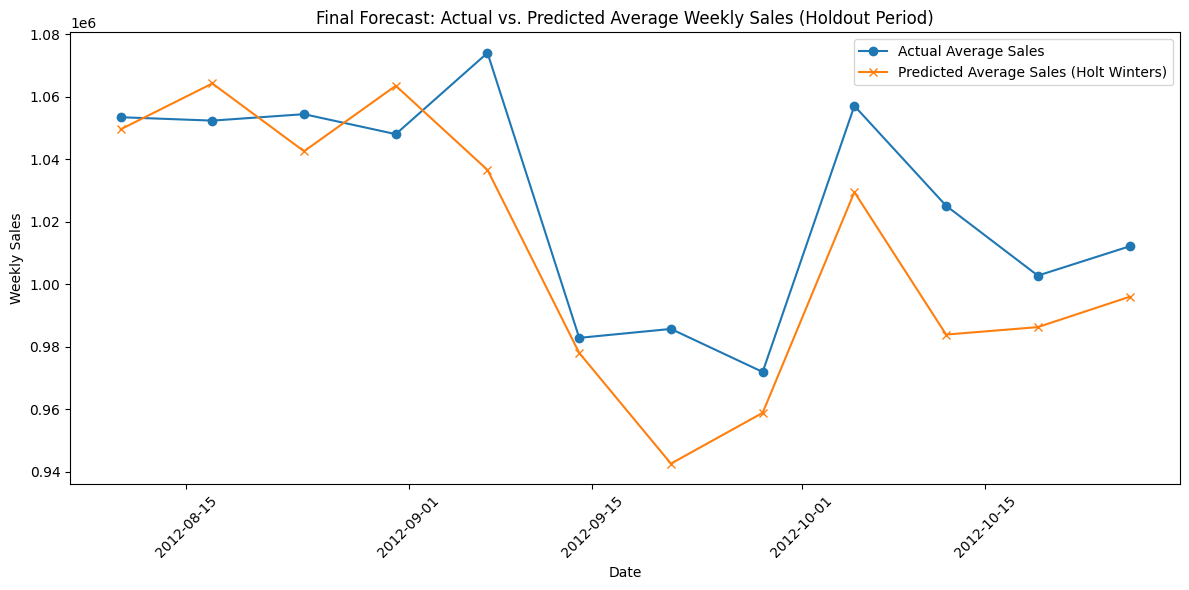

In [37]:
sorted_dates = sorted(pred_by_date.keys())
avg_pred = [np.mean(pred_by_date[dt]) for dt in sorted_dates]
avg_actual = [np.mean(actual_by_date[dt]) for dt in sorted_dates]

plt.figure(figsize=(12, 6))
plt.plot(sorted_dates, avg_actual, marker='o', label='Actual Average Sales')
plt.plot(sorted_dates, avg_pred, marker='x', label='Predicted Average Sales (Holt Winters)')
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Final Forecast: Actual vs. Predicted Average Weekly Sales (Holdout Period)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ToDo
1. Use Darts libary's anamoly detector + forecaster to incorporate actual 'holidays' events that boost sales in forecasting.
2. Analysze residuals. Check the Ljung-Box test for residuals.
3. Add another loss metric too?
4. Use SHAP to analyse models post training.
5. Create results_dict as json convertible object and save it to a file.
6. STL and MSTL forecasting.